# Load


## libs

In [1]:
suppressPackageStartupMessages({
    source('../../libs.R')
    source('../../utils.R')    
    source('../../Figures/colors.R')    
#     source('../../utils_mapping.R') ## For get_ortho() 
    source('../../utils_plotting.R')
})


## obj

Needed? 

In [2]:
# dname <- '/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/'
# fields_load <- c('meta_data', 'umap_after', 'effects_nested', 'effects_marginal')
# obj <- map(fields_load, function(name) {
#     readRDS(file.path(dname, paste0(name, '.rds')))
# })
# names(obj) <- fields_load


## cluster markers 

In [2]:
effects_mm <- readRDS('/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/effects_mm.rds')


## DSS

In [3]:
counts <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/counts.rds')
meta_data <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/metadata.rds') %>% data.frame()
rownames(meta_data) <- meta_data$LibraryID
logcpm <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/logcpm.rds')
# dlogcpm <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/dlogcpm.rds')
ortho <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/ortho.rds')

# ## Scale across all timepoints 
# dlogcpm_scaled <- scaleData(dlogcpm, 1, 5)

# ## Remove 0 variance genes 
# dlogcpm_scaled <- dlogcpm_scaled[which(!apply(is.nan(dlogcpm_scaled), 1, any)), ]


## Remove outliers

In [4]:
meta_data <- subset(meta_data, !LibraryID %in% c('Lib1_B'))
counts <- counts[, meta_data$LibraryID]
logcpm <- logcpm[, meta_data$LibraryID]

# gut single cell cluster markers 

## data

In [5]:
mm_sc <- list()
mm_sc$meta_data <- readRDS('/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/meta_data.rds')
mm_sc$counts <- readRDS('/data/srlab2/ik936/Roche/data/cache/mouse_query_joint/exprs_raw.rds')
mm_sc$meta_data <- subset(mm_sc$meta_data, Tissue == 'Gut')
mm_sc$counts <-  mm_sc$counts[, mm_sc$meta_data$CellID]

In [6]:
dim(mm_sc$counts)

[1] 32918  6979

## Presto

In [30]:
## Collapse Counts
pb <- presto::collapse_counts(
#     mm_sc$counts,
#     mm_sc$meta_data, 
    mm_sc$counts[, subset(mm_sc$meta_data, Cluster != 'C13')$CellID],
    subset(mm_sc$meta_data, Cluster != 'C13'), 
    c('Cluster', 'LibraryID'),
    keep_n=TRUE, 
    how='sum'
) 
pb$meta_data$logUMI <- log(colSums(pb$counts_mat))

## need integers for GLMM
## this is only a problem for ortholog counts because of many to many mapping 
pb$counts_mat_int <- matrix(as.integer(pb$counts_mat), ncol = ncol(pb$counts_mat))
rownames(pb$counts_mat_int) <- rownames(pb$counts_mat)
colnames(pb$counts_mat_int) <- colnames(pb$counts_mat)

CAREFUL: get_norm makes very strong assumptions about data



In [31]:
genes_test <- rownames(pb$counts_mat)[which(rowSums(pb$counts_mat >= 3) >= 3)]
length(genes_test)


[1] 13626

In [32]:
## Fit Models
t2 <- system.time({
    suppressWarnings({
        mm_sc$presto <- presto.presto(
            formula = y~1+(1|Cluster)+(1|LibraryID/Cluster)+offset(logUMI), 
            design = pb$meta_data, 
            response = pb$counts_mat, 
            size_varname = 'logUMI',
#             features = genes_test,
            features = c('Pdpn', 'Pdgfra'),
            ncore = 20,
            nsim = 1e3,
            effects_cov = c('Cluster'),
            min_sigma = .5,
            verbose = 1
        ) 
    })
})


CAUTION: if using GLMM, make sure your counts are integers!

Set up models

Learn the models

Aggregate the results

Cleap up names

Joining, by = "grpvar_orig"

Compute gene means



## Effects

In [33]:
contrasts_mat <- make_contrast.presto(mm_sc$presto, 'Cluster')
effects <- contrasts.presto(mm_sc$prest, contrasts_mat, one_tailed = FALSE) %>% 
#     tidyr::separate(contrast, c('Cluster', 'Tissue'), sep = '\\|', remove = FALSE) %>% 
    dplyr::rename(Cluster = contrast) %>% 
    arrange(pvalue)


In [36]:
effects %>% 
    subset(Cluster %in% c('C11', 'C4')) %>% 
    arrange(beta)

Cluster,feature,beta,sigma,zscore,pvalue
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
C4,Pdgfra,-0.2931241,0.2143898,-1.3672483,0.1715475
C11,Pdgfra,-0.2497807,0.2254883,-1.1077321,0.2679775
C4,Pdpn,-0.1560224,0.2038383,-0.7654225,0.4440200
C11,Pdpn,0.2048618,0.2320222,0.8829409,0.3772682


In [177]:
# effects %>% 
#     subset(feature == 'Col3a1') %>% 
#     arrange(-beta) %>% 
#     head(3)

# effects_mm %>% 
#     subset(feature == 'Col3a1') %>% 
#     arrange(-beta) %>% 
#     head(3)

In [150]:
# table(gut_sc$meta_data$lineage)

# head(gut_sc$meta_data)
# nrow(gut_sc$meta_data)

## Cache

In [179]:
saveRDS(mm_sc$presto, '/data/srlab2/ik936/Roche/data/cache/mm_presto_gut.rds')
saveRDS(effects, '/data/srlab2/ik936/Roche/data/cache/mm_presto_gut_effects.rds')

# Timecourse plots (genesets) 

In [182]:
effects_mm <- readRDS('/data/srlab2/ik936/Roche/data/cache/mm_presto_gut_effects.rds')

## Genesets

In [276]:
genesets <- data.table(effects_mm)[
    Cluster != 'C7' ## this was a poor QC cluster
][
    pvalue < .05 & beta > log(2) & feature %in% rownames(dlogcpm_scaled)
] %>% 
    split(.$Cluster) %>%
    map('feature') 

map(genesets, length)


$C0
[1] 43

$C1
[1] 187

$C10
[1] 399

$C11
[1] 95

$C12
[1] 88

$C13
[1] 528

$C2
[1] 30

$C3
[1] 36

$C4
[1] 51

$C5
[1] 138

$C6
[1] 321

$C8
[1] 201

$C9
[1] 349

## Plots (SS = day0)

In [280]:
plt_df <- genesets %>% imap(function(g, .name) {
    g <- g[which(apply(logcpm[g, ], 1, sd) > 0)]
    X <- scaleData(logcpm[g, ], 1, 10)
    meta_data[colnames(logcpm), ] %>% 
    cbind(val = colSums(X) / sqrt(length(g))) %>% 
#     subset(Case == 'DSS') %>% 
    dplyr::mutate(TimeInt = case_when(
        Case == 'SS' ~ 0L, 
        TRUE ~ TimeInt
    )) %>% 
    cbind(gs = .name)
    
}) %>%
    bind_rows()



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



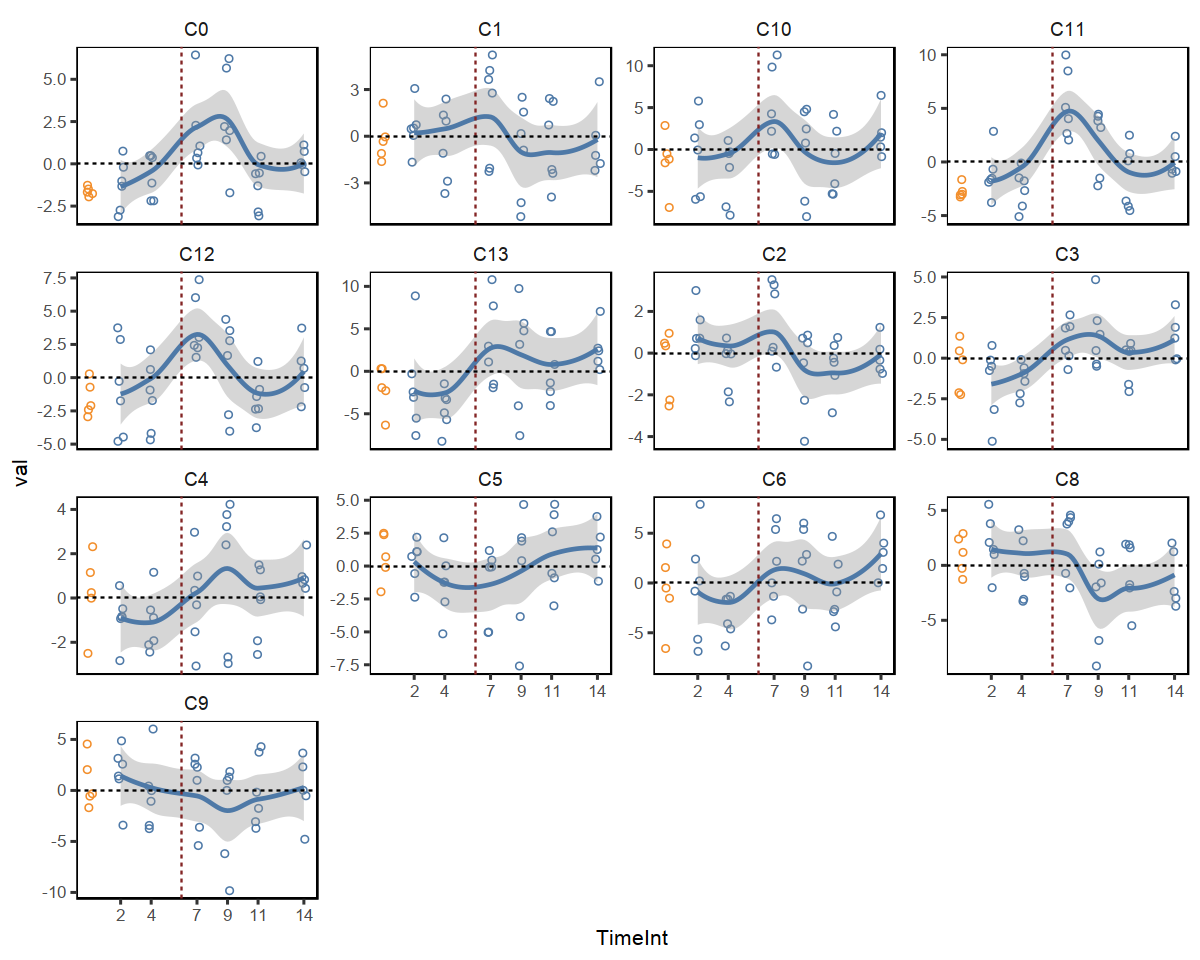

In [281]:
fig.size(8, 10)

ggplot(plt_df, aes(TimeInt, val, color = Case)) + 
    geom_point(shape = 21, position = position_jitter(width = .2, height = 0)) + 
    geom_smooth(data = . %>% subset(Case == 'DSS')) + 
    guides(color = 'none') + 
#         geom_text_repel(
# #             data = . %>% subset(Case == 'SS'), 
#             data = . %>% subset(grepl('^Lib1_', LibraryID)), 
#             aes(label = gsub('Lib(\\d+)_.', '\\1', LibraryID))
#         ) + 
    scale_x_continuous(breaks = unique(meta_data$TimeInt)) + 
#         theme(
#             axis.text.x = element_blank(),
#             axis.ticks.x = element_blank()
#         ) + 
    geom_vline(xintercept = 6, linetype = 2, color = muted('red')) + 
#         theme_void(base_size = 14) + 
#             labs(title = .mod) + 
    scale_color_tableau() + 
    geom_hline(yintercept = 0, linetype = 2) + 
    facet_wrap(~gs, scales = 'free_y') + 
    NULL    


In [688]:
# effects_mm %>% 
# #     subset(Cluster == 'C4') %>% 
#     subset(feature %in% c('Pdpn', 'Pdgfra')) %>% 
#     arrange(beta)

## Plots (SS by time)

In [530]:
plt_df <- genesets %>% imap(function(g, .name) {
    g <- g[which(apply(logcpm[g, ], 1, sd) > 0)]
    X <- scaleData(logcpm[g, ], 1, 10)
    meta_data[colnames(logcpm), ] %>% 
    cbind(val = colSums(X) / sqrt(length(g))) %>% 
#     subset(Case == 'DSS') %>% 
#     dplyr::mutate(TimeInt = case_when(
#         Case == 'SS' ~ 0L, 
#         TRUE ~ TimeInt
#     )) %>% 
    cbind(gs = .name)
    
}) %>%
    bind_rows()



`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“span too small.   fewer data values than degrees of freedom.”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 1.94”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 5.06”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  0”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“There are other near singularities as well. 49.844”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 5”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“Chernobyl! trL>n 5”
Warning message in sqrt(sum.squares/one.delta):
“NaNs produced”

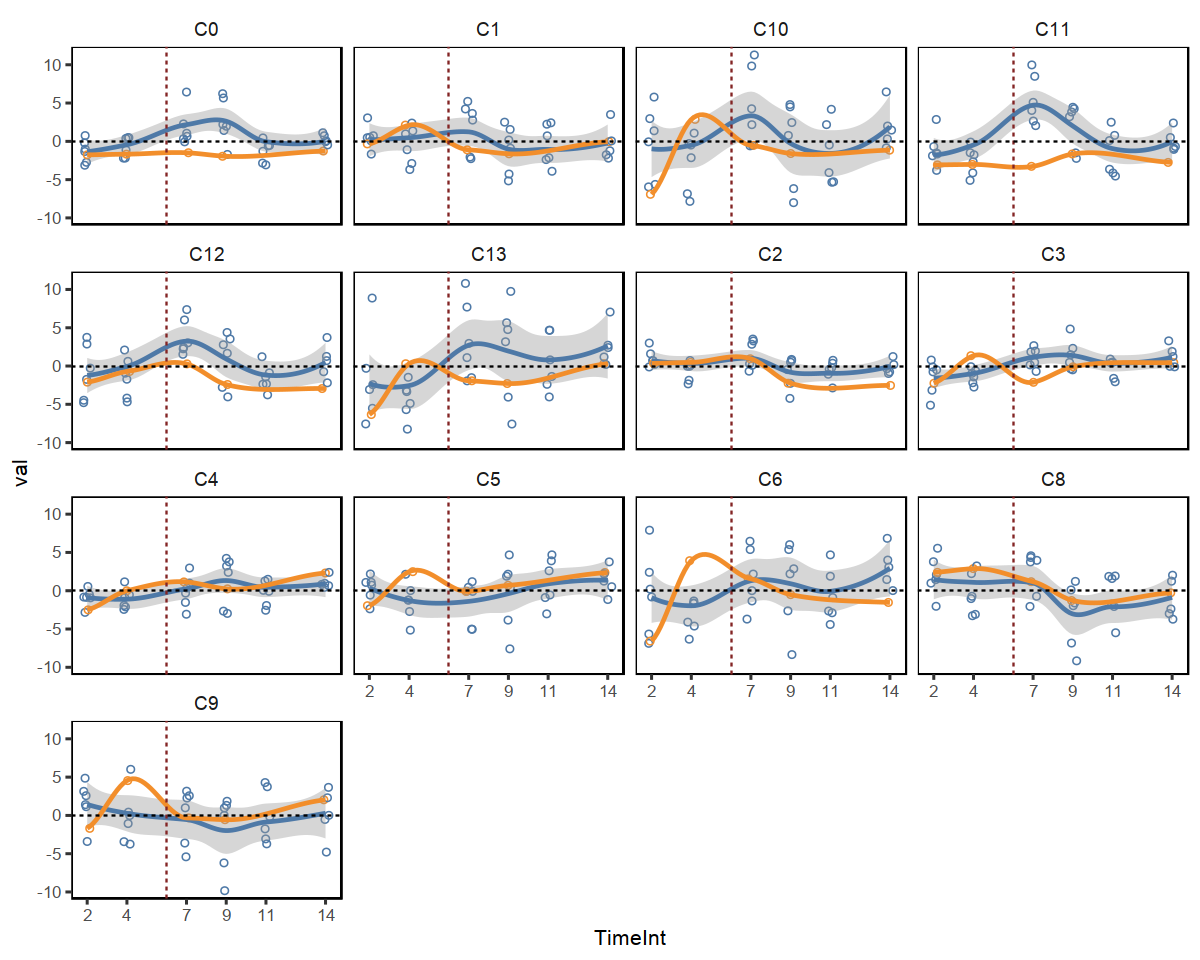

In [531]:
fig.size(8, 10)

ggplot(plt_df, aes(TimeInt, val, color = Case)) + 
    geom_point(shape = 21, position = position_jitter(width = .2, height = 0)) + 
    geom_smooth() + 
#     geom_smooth(data = . %>% subset(Case == 'DSS')) + 
    guides(color = 'none') + 
#         geom_text_repel(
# #             data = . %>% subset(Case == 'SS'), 
#             data = . %>% subset(grepl('^Lib1_', LibraryID)), 
#             aes(label = gsub('Lib(\\d+)_.', '\\1', LibraryID))
#         ) + 
    scale_x_continuous(breaks = unique(meta_data$TimeInt)) + 
#         theme(
#             axis.text.x = element_blank(),
#             axis.ticks.x = element_blank()
#         ) + 
    geom_vline(xintercept = 6, linetype = 2, color = muted('red')) + 
#         theme_void(base_size = 14) + 
#             labs(title = .mod) + 
    scale_color_tableau() + 
    geom_hline(yintercept = 0, linetype = 2) + 
    facet_wrap(~gs) + 
#     facet_wrap(~gs, scales = 'free_y') + 
    NULL    


## Plots (dlogcpm)

In [527]:
plt_df <- genesets %>% imap(function(g, .name) {
    g <- g[which(apply(dlogcpm[g, ], 1, sd) > 0)]
    X <- scaleData(dlogcpm[g, ], 1, 10)
    meta_data[colnames(dlogcpm), ] %>% 
    cbind(val = colSums(X) / sqrt(length(g))) %>% 
#     subset(Case == 'DSS') %>% 
#     dplyr::mutate(TimeInt = case_when(
#         Case == 'SS' ~ 0L, 
#         TRUE ~ TimeInt
#     )) %>% 
    cbind(gs = .name)
    
}) %>%
    bind_rows()



`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 9”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 5”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  9.4448e-18”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 9”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 5”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :


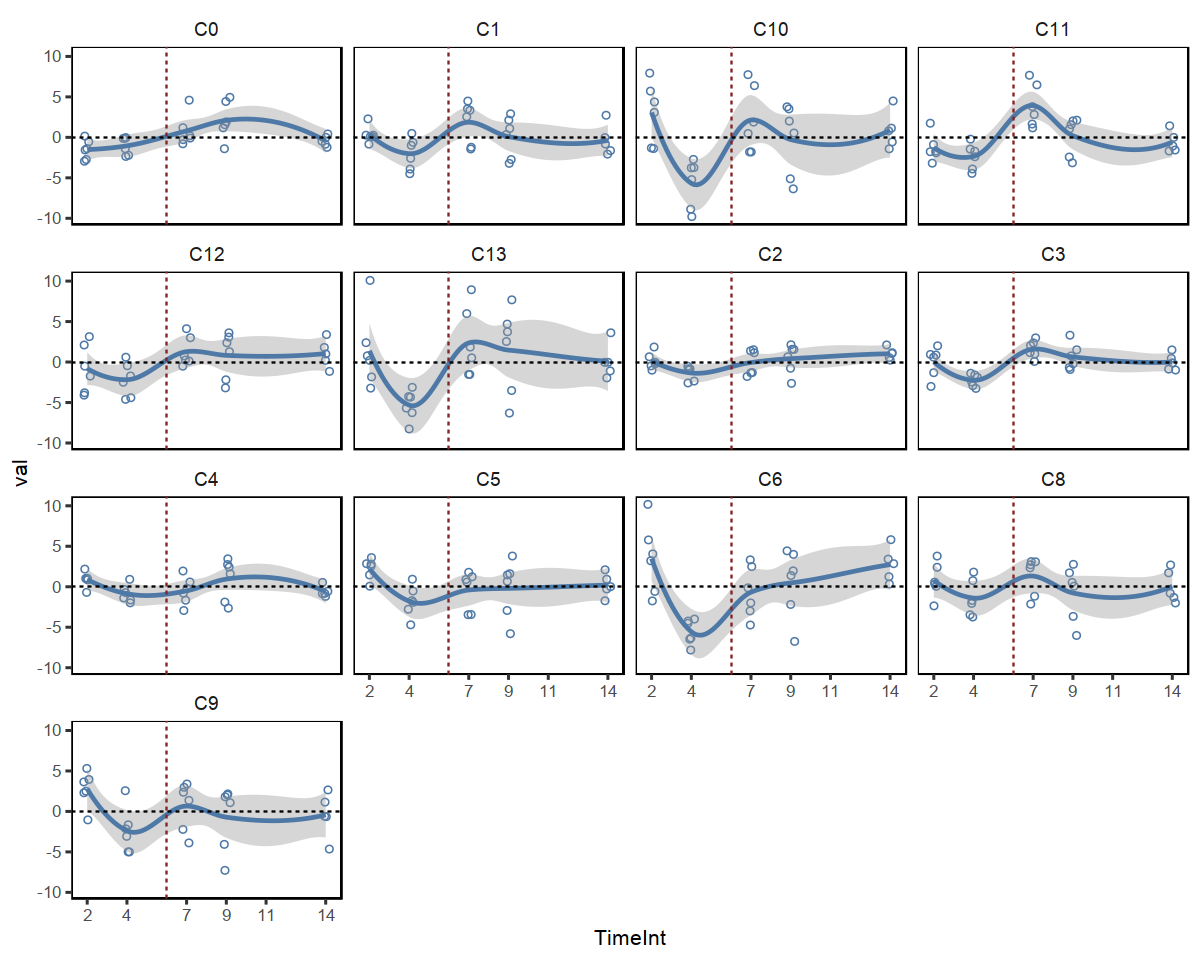

In [529]:
fig.size(8, 10)

ggplot(plt_df, aes(TimeInt, val, color = Case)) + 
    geom_point(shape = 21, position = position_jitter(width = .2, height = 0)) + 
    geom_smooth() + 
#     geom_smooth(data = . %>% subset(Case == 'DSS')) + 
    guides(color = 'none') + 
#         geom_text_repel(
# #             data = . %>% subset(Case == 'SS'), 
#             data = . %>% subset(grepl('^Lib1_', LibraryID)), 
#             aes(label = gsub('Lib(\\d+)_.', '\\1', LibraryID))
#         ) + 
    scale_x_continuous(breaks = unique(meta_data$TimeInt)) + 
#         theme(
#             axis.text.x = element_blank(),
#             axis.ticks.x = element_blank()
#         ) + 
    geom_vline(xintercept = 6, linetype = 2, color = muted('red')) + 
#         theme_void(base_size = 14) + 
#             labs(title = .mod) + 
    scale_color_tableau() + 
    geom_hline(yintercept = 0, linetype = 2) + 
    facet_wrap(~gs) + 
    NULL    


## Stats

In [286]:
.x <- plt_df %>% 
    subset(gs == 'C11')


In [291]:
# subset(.x, Case == 'SS')
subset(.x, Case == 'DSS') %>% 
    split(.$TimePoint) %>% 
    


,LibraryID,Code,TimePoint,TimeInt,Case,Cage,Depth,val,gs
,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Lib10_B...121,Lib10_B,10,D4,4,DSS,B,17674678,-5.0982168,C11
Lib11_B...122,Lib11_B,11,D4,4,DSS,C,25765938,-1.7594319,C11
Lib12_B...123,Lib12_B,12,D4,4,DSS,D,25148334,-2.6734451,C11
Lib13_B...124,Lib13_B,13,D4,4,DSS,E,34238423,-1.4866903,C11
Lib14_B...125,Lib14_B,14,D4,4,DSS,F,26818860,-4.1137097,C11
Lib16_B...127,Lib16_B,16,D7,7,DSS,A,30148642,2.6550301,C11
Lib17_B...128,Lib17_B,17,D7,7,DSS,B,28637402,5.0931418,C11
Lib18_B...129,Lib18_B,18,D7,7,DSS,C,25591411,8.4896032,C11
Lib19_B...130,Lib19_B,19,D7,7,DSS,D,29062150,2.0492781,C11


# Per-gene tests 

In [30]:
m <- meta_data %>% 
    dplyr::mutate(
        TimePoint = case_when(
            Case == 'SS' ~ 'D0', 
            TRUE ~ TimePoint
        ),
        TimeInt = case_when(
            Case == 'SS' ~ 0L, 
            TRUE ~ TimeInt
        )        
    ) %>% 
    dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14))))

## Dynamics differential expression (splines) 

In [550]:
library(VGAM) ## for sm.ns 
library(limma)

lres_dynamic <- lmFit(logcpm[, m$LibraryID], model.matrix(~sm.ns(TimeInt, df = 4), m)) %>% 
    eBayes() %>% 
    topTable(number = Inf) %>% 
    tibble::rownames_to_column('feature') %>% 
    subset(feature %in% unique(effects_mm$feature)) %>% ## Fewer genes = easier FDR 
    dplyr::mutate(fdr = p.adjust(P.Value, 'BH')) 


Warning message:
“Zero sample variances detected, have been offset away from zero”
Removing intercept from test coefficients



In [551]:
lres_dynamic %>% subset(feature %in% c('Cxcl9', 'Cxcl10'))

,feature,sm.ns.TimeInt..df...4.1,sm.ns.TimeInt..df...4.2,sm.ns.TimeInt..df...4.3,sm.ns.TimeInt..df...4.4,AveExpr,F,P.Value,adj.P.Val,fdr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
148,Cxcl9,4.808346,0.6072031,-0.2730028,2.658858,1.251774,5.529730,0.001460753,0.5411302,0.2013721
11059,Cxcl10,3.658123,-1.1019509,-1.6553612,1.652661,2.099180,1.111235,0.366672589,1.0000000,0.9395394


[1] 116

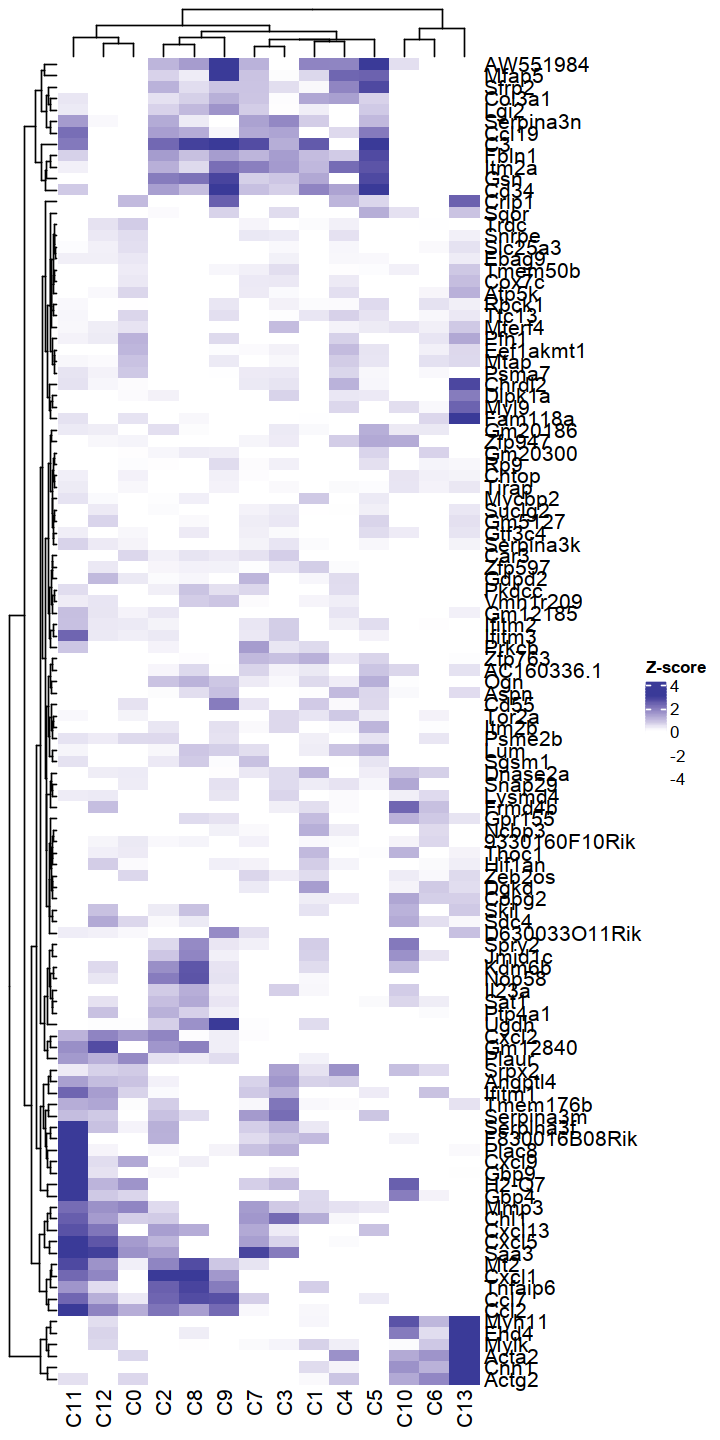

In [552]:
## Are these genes enriched in cluster markers? 
genes_dynamic <- subset(lres_dynamic, fdr < .21)$feature
length(genes_dynamic)
fig.size(12, 6)
effects_mm %>% 
    subset(feature %in% genes_dynamic) %>% 
    dplyr::select(SCORE=zscore, feature, Cluster) %>% 
#     dplyr::select(SCORE=beta, feature, Cluster) %>% 
    tidyr::spread(Cluster, SCORE) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% 
#     t %>% scale %>% t %>% ## Optionally, scale each gene 
    Heatmap(
        colorRamp2(c(-3, 0, 3), c('white', 'white', muted('blue'))),     
        name = 'Z-score'
    )


In [553]:
# lres_dynamic %>% 
#     subset(fdr < .2) %>% 
#     dplyr::select(feature, matches('^sm.ns')) %>% 
#     tibble::remove_rownames() %>% 
#     tibble::column_to_rownames('feature') %>% 
#     apply(1, max) %>% 
#     data.frame() %>% 
#     arrange(-`.`)

## LIMMA (peak expression)

P values are really weird when we pool all the data together ... 


In [554]:
library(limma)
g <- unique(effects_mm$feature) %>% intersect(rownames(logcpm))
lres_peaks <- map(paste0('D', c(2, 4, 7, 9, 11, 14)), function(.timepoint) {
    .m <- m %>% subset(TimePoint %in% c('D0', .timepoint)) %>% dplyr::mutate(TimePoint = as.character(TimePoint))
    
    suppressWarnings({
        lmFit(logcpm[g, .m$LibraryID], model.matrix(~1+TimePoint, .m)) %>% 
            eBayes() %>% 
            topTable(number = Inf) %>% 
            tibble::rownames_to_column('feature') %>% 
            cbind(TimePoint = .timepoint) 
    })
    
}) %>% bind_rows()

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients

Removing intercept from test coefficients



In [555]:
## Get dynamic genes that are upregulated
genes_dynamic_pos <- lres_peaks %>% 
    subset(feature %in% genes_dynamic) %>% 
    subset(logFC > 0 & P.Value < .05) %>% 
    with(unique(feature)) 
length(genes_dynamic_pos)

[1] 78

In [270]:
# lres_peaks %>% 
#     subset(adj.P.Val < .2) %>% 
#     split(.$TimePoint) %>% 
#     map(dplyr::arrange, -t) %>% 
#     map(subset, logFC >= 0) %>% 
# #     map(subset, fdr < .1) %>% 
# #     map(subset, logFC >= 0 & adj.P.Val < .2) %>% 
# #     map(subset, logFC >= 1 & P.Value < .05) %>% 
# #     map(head, 10)
# #     map(nrow)
#     identity()


## Comparison

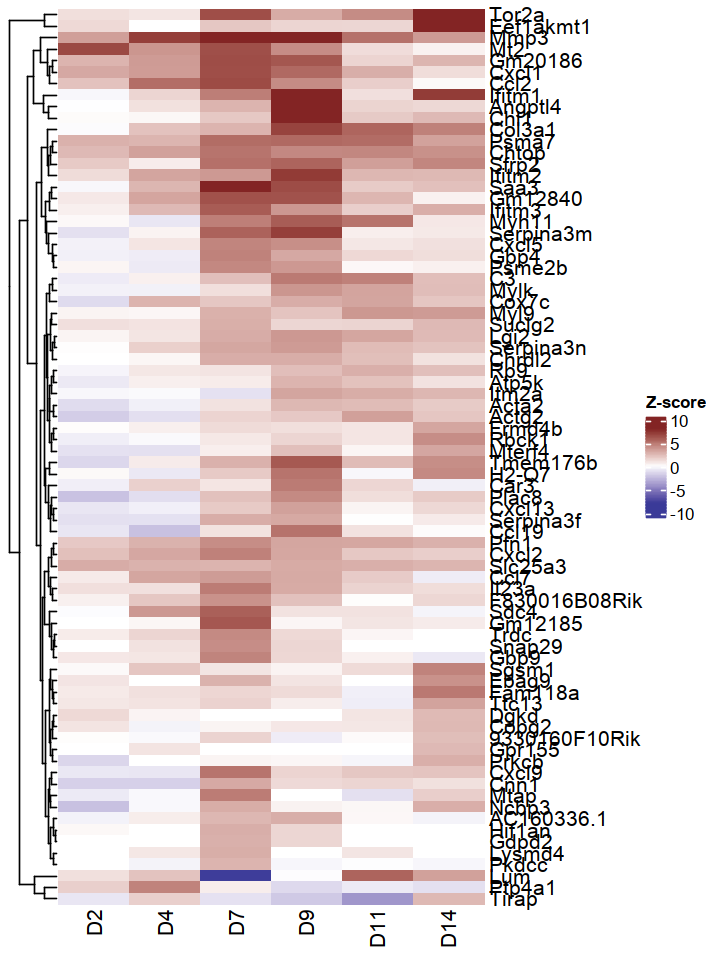

In [556]:
fig.size(8, 6)
## Comparison to dynamic genes 
X <- lres_peaks %>% 
    subset(feature %in% genes_dynamic_pos) %>%     
#     dplyr::select(SCORE=logFC, feature, TimePoint) %>% 
    dplyr::select(SCORE=t, feature, TimePoint) %>% 
    tidyr::spread(TimePoint, SCORE) %>% 
    tibble::column_to_rownames('feature') %>% 
    as.matrix() %>% 
#     t() %>% scale() %>% t() %>% 
    identity()

Heatmap(
    X[, paste0('D', c(2, 4, 7, 9, 11, 14))], 
    colorRamp2(c(-8, 0, 8), c(muted('blue'), 'white', muted('red'))),     
    name = 'Z-score',
    cluster_columns = FALSE
)


## Gene time plots

In [557]:
m <- meta_data %>% 
    dplyr::mutate(TimeInt = case_when(
        Case == 'SS' ~ 0L, 
        TRUE ~ TimeInt
    )) %>% 
    dplyr::mutate(TimePoint = case_when(
        Case == 'SS' ~ 'D0', 
        TRUE ~ TimePoint
    )) %>% 
    dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14))))



In [558]:
# effects_mm %>% subset(feature == 'Thy1') %>% arrange(-beta)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



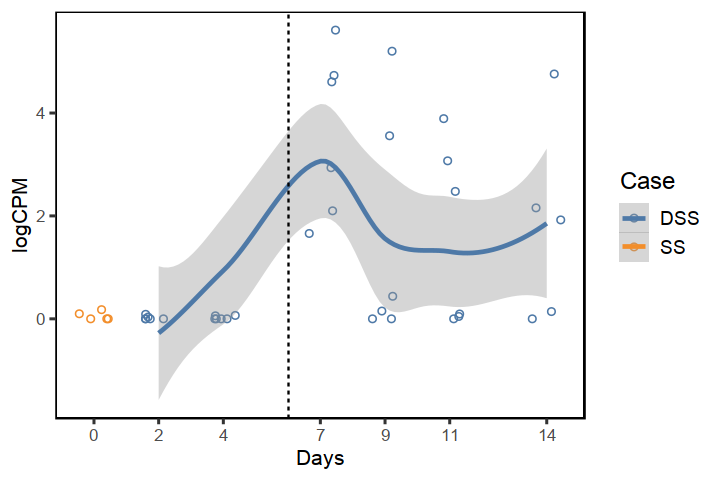

In [559]:
# .g <- 'Thy1'
# .g <- 'Col3a1'
.g <- 'Cxcl9'
# .g <- 'Cxcl10'
# .g <- 'Ccl19'
# .g <- 'Postn'
# .g <- 'Sparc'
# .g <- 'Irf7'
# .g <- 'Vegfa'
# .g <- 'Wfdc1'
# .g <- 'Cd74'

fig.size(4, 6)
m %>% 
    cbind(val = logcpm[.g, m$LibraryID]) %>% 
    ggplot(aes(TimeInt, val, color = Case)) + 
        geom_point(shape = 21, position = position_jitter(width = .5, height = 0)) + 
        scale_color_tableau() + 
        geom_smooth(
#             data = . %>% subset(Case == 'DSS')
#             color = 'black'
        ) + 
        scale_x_continuous(breaks = unique(m$TimeInt)) + 
        labs(y = 'logCPM', x = 'Days') + 
        geom_vline(xintercept = 6, linetype = 2) + 
        NULL
        


## Gene time plots (paired) 

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at 9”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 5”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  9.4448e-18”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“pseudoinverse used at 9”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :
“neighborhood radius 5”
Warning message in predLoess(object$y, object$x, newx = if (is.null(newdata)) object$x else if (is.data.frame(newdata)) as.matrix(model.frame(delete.response(terms(object)), :


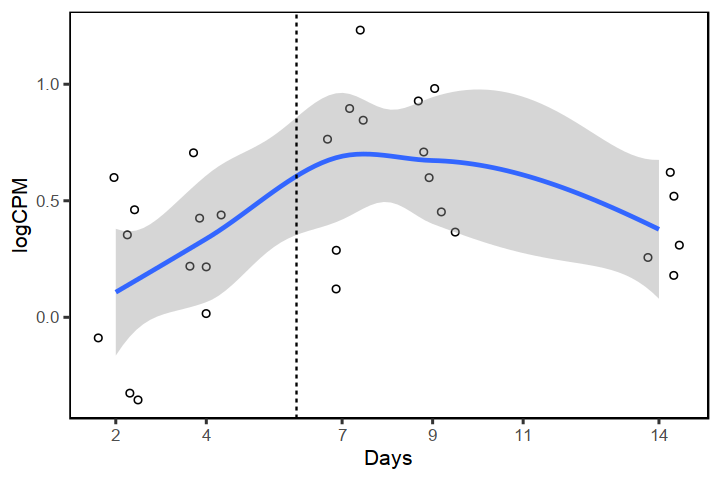

In [511]:
# .g <- 'Thy1'
# .g <- 'Wfdc1'
# .g <- 'Postn'
# .g <- 'Sparc'
.g <- 'Col3a1'

fig.size(4, 6)

suppressWarnings({
    meta_data[colnames(dlogcpm), ] %>% 
        cbind(val = dlogcpm[.g, ]) %>% 
        ggplot(aes(TimeInt, val)) + 
            geom_point(shape = 21, position = position_jitter(width = .5, height = 0)) + 
            scale_color_tableau() + 
            geom_smooth() + 
            scale_x_continuous(breaks = unique(m$TimeInt)) + 
            labs(y = 'logCPM', x = 'Days') + 
            geom_vline(xintercept = 6, linetype = 2) + 
            NULL
})


## Enrichment in clusters (analysis)

In [45]:
m <- meta_data %>% 
    dplyr::mutate(
        TimePoint = case_when(
            Case == 'SS' ~ 'D0', 
            TRUE ~ TimePoint
        ),
        TimeInt = case_when(
            Case == 'SS' ~ 0L, 
            TRUE ~ TimeInt
        )        
    ) %>% 
    dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14)))) %>% 
    dplyr::arrange(TimePoint)

In [48]:
set.seed(44L)
X <- scaleData(logcpm[genes_dynamic_pos, m$LibraryID], 1, 5)
hres <- hclust(dist(X), method = 'complete') %>% cutree(2)
hres <- data.frame(group=hres)
hres$group <- LETTERS[hres$group]
hres <- hres %>% 
    tibble::rownames_to_column('LibraryID') %>% 
    left_join(tibble(group = c('A', 'B'), Class = c('Inflammation', 'Resolution'))) %>% 
#     left_join(tibble(group = c('A', 'B', 'C'), Class = c('Inflam', 'Early', 'Late'))) %>% 
    tibble::column_to_rownames('LibraryID') %>% 
    dplyr::select(-group)

Joining, by = "group"



## Z-scores

In [49]:
enrich_res <- split(rownames(hres), hres$Class) %>% map(function(g) {
    effects_mm %>% 
#         subset(feature %in% rownames(subset(hres, Class == 'Inflam'))) %>% 
        subset(feature %in% g) %>% 
        split(.$Cluster) %>% 
        map(function(.SD) data.frame(zscore = sum(.SD$zscore) / sqrt(nrow(.SD)))) %>% 
        bind_rows(.id = 'Cluster') %>% 
        arrange(-zscore) %>% 
        dplyr::mutate(p = abs(pnorm(zscore, log.p = TRUE))) ## one sided
    
}) %>% 
    bind_rows(.id = 'Class') %>% 
    dplyr::mutate(padj = p.adjust(p, 'BH')) %>%
#     dplyr::mutate(padj = p.adjust(p, 'bonferroni')) %>%
    
    arrange(-zscore)
head(enrich_res)

,Class,Cluster,zscore,p,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,Inflammation,C11,8.361754,3.089627e-17,8.650955e-16
2,Inflammation,C12,3.577493,1.734680e-04,2.428552e-03
3,Inflammation,C2,2.373039,8.860341e-03,8.269652e-02
4,Inflammation,C7,2.004563,2.276199e-02,1.593339e-01
5,Inflammation,C0,1.457365,7.527086e-02,4.215168e-01
6,Inflammation,C3,1.244257,1.128357e-01,5.265666e-01


## GSEA


In [65]:
library(fgsea)

In [63]:
gs <- split(rownames(hres), hres$Class)

In [122]:
enrich_res <- effects_mm %>% 
    split(.$Cluster) %>% 
    imap(function(.SD, .cluster) {
        .x <- .SD$zscore
#         .x <- .SD$beta
        names(.x) <- .SD$feature
        fgsea::fgseaMultilevel(gs, .x, eps=1e-30)
#         fgsea::fgseaSimple(gs, .x, scoreType='pos', nperm = 1e5)

    }) %>% 
    bind_rows(.id = 'Cluster') %>% 
    arrange(-NES)
#     arrange(-zscore) %>% 
#     dplyr::mutate(p = abs(pnorm(zscore, log.p = TRUE))) ## one sided

In [123]:
enrich_res %>% subset(padj < .01) %>% head()

Cluster,pathway,pval,padj,log2err,ES,NES,size,leadingEdge
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
C11,Inflammation,4.746245e-19,9.492491e-19,1.1239150,0.8311110,3.093872,58,"Gbp4 , Ccl2 , Cxcl9 , Saa3 , Plac8 , Gbp9 , Serpina3f , F830016B08Rik, Cxcl5 , Mt2 , Cxcl13 , Chl1 , Ifitm1 , Ifitm3 , Ccl7 , Cxcl1 , Mmp3 , Ccl19 , C3 , Gm12840 , Serpina3n , Angptl4 , Tmem176b , Cxcl2 , Serpina3m , Gm12185 , Ifitm2"
C12,Inflammation,1.645549e-09,3.291099e-09,0.7881868,0.6361237,2.593162,58,"Saa3 , Gm12840 , Cxcl5 , Cxcl13 , Ccl2 , Cxcl2 , Cxcl1 , Mmp3 , Mt2 , Chl1 , Ifitm1 , Tmem176b , Sdc4 , Ccl7 , Gdpd2 , Angptl4 , Serpina3f, Serpina3m, Gbp4 , Hif1an"
C2,Inflammation,3.145764e-06,6.291528e-06,0.6272567,0.5538902,2.227567,58,"Cxcl1 , Ccl7 , C3 , Ccl2 , Mt2 , Cxcl2 , Gm12840 , Saa3 , Ccl19 , Cxcl13 , Serpina3n , Serpina3f , F830016B08Rik, Sfrp2 , Cxcl5 , Serpina3m , Il23a , Chl1 , Tmem176b , Lgi2"
C7,Inflammation,8.315555e-04,1.663111e-03,0.4772708,0.5038958,1.811198,58,"Saa3 , C3 , Chl1 , Serpina3m , Mmp3 , Cxcl5 , Serpina3n , Ccl19 , Cxcl13 , Gdpd2 , Plac8 , Sfrp2 , Col3a1 , Ifitm1 , Lgi2 , Serpina3f , Ccl7 , Angptl4 , AC160336.1, Pkdcc"
C5,Inflammation,1.802799e-03,3.605599e-03,0.4550599,-0.4572323,-1.698405,58,"Actg2 , Ccl2 , Gbp4 , Saa3 , Cxcl5 , Cxcl2 , Gm12840 , Mylk , Acta2 , F830016B08Rik, Pkdcc , Sdc4 , Cnn1 , Gbp9 , Gm12185 , Myh11 , Cxcl9 , Il23a , Atp5k , Serpina3f"
C13,Inflammation,1.303119e-03,2.606238e-03,0.4550599,-0.5196569,-1.785161,58,"C3 , Chl1 , Cxcl13 , Ccl2 , Mmp3 , Ccl7 , Cxcl1 , Saa3 , Ifitm1 , Mt2 , Serpina3n , Ccl19 , F830016B08Rik, Cxcl5 , Angptl4 , Col3a1 , Lgi2 , Sfrp2 , Gm12840 , Serpina3f , Ifitm3"


In [124]:
enrich_res %>% split(.$pathway) %>% map(head)

,Cluster,pathway,pval,padj,log2err,ES,NES,size,leadingEdge
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
1,C11,Inflammation,4.746245e-19,9.492491e-19,1.1239150,0.8311110,3.093872,58,"Gbp4 , Ccl2 , Cxcl9 , Saa3 , Plac8 , Gbp9 , Serpina3f , F830016B08Rik, Cxcl5 , Mt2 , Cxcl13 , Chl1 , Ifitm1 , Ifitm3 , Ccl7 , Cxcl1 , Mmp3 , Ccl19 , C3 , Gm12840 , Serpina3n , Angptl4 , Tmem176b , Cxcl2 , Serpina3m , Gm12185 , Ifitm2"
2,C12,Inflammation,1.645549e-09,3.291099e-09,0.7881868,0.6361237,2.593162,58,"Saa3 , Gm12840 , Cxcl5 , Cxcl13 , Ccl2 , Cxcl2 , Cxcl1 , Mmp3 , Mt2 , Chl1 , Ifitm1 , Tmem176b , Sdc4 , Ccl7 , Gdpd2 , Angptl4 , Serpina3f, Serpina3m, Gbp4 , Hif1an"
3,C2,Inflammation,3.145764e-06,6.291528e-06,0.6272567,0.5538902,2.227567,58,"Cxcl1 , Ccl7 , C3 , Ccl2 , Mt2 , Cxcl2 , Gm12840 , Saa3 , Ccl19 , Cxcl13 , Serpina3n , Serpina3f , F830016B08Rik, Sfrp2 , Cxcl5 , Serpina3m , Il23a , Chl1 , Tmem176b , Lgi2"
4,C7,Inflammation,8.315555e-04,1.663111e-03,0.4772708,0.5038958,1.811198,58,"Saa3 , C3 , Chl1 , Serpina3m , Mmp3 , Cxcl5 , Serpina3n , Ccl19 , Cxcl13 , Gdpd2 , Plac8 , Sfrp2 , Col3a1 , Ifitm1 , Lgi2 , Serpina3f , Ccl7 , Angptl4 , AC160336.1, Pkdcc"
5,C3,Inflammation,1.021840e-02,2.043680e-02,0.3807304,0.4041898,1.557365,58,"Chl1 , Serpina3m , Tmem176b , Saa3 , Serpina3n , Angptl4 , Ccl19 , C3 , Plac8 , Ifitm1 , Serpina3f , F830016B08Rik, Mmp3 , Ifitm3 , Ifitm2 , Car3 , Il23a"
6,C0,Inflammation,1.424232e-02,2.848463e-02,0.3807304,0.4135970,1.549980,58,"Mmp3 , Saa3 , Cxcl2 , Cxcl5 , Cxcl9 , Ccl2 , Pfn1 , Mtap , Angptl4, Psma7 , Trdc , Chl1 , Ifitm1 , Gbp4 , Atp5k , Acta2 , Actg2 , Car3 , Sdc4"
,Cluster,pathway,pval,padj,log2err,ES,NES,size,leadingEdge
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<list>
1,C11,Resolution,0.2169312,0.2169312,0.15315881,0.4161316,1.2164698,20,"H2-Q7 , Prkcb , Sgsm1 , Fam118a, Tirap , Ebag9 , Itm2a"


In [114]:
# enrich_res <- split(rownames(hres), hres$Class) %>% map(function(g) {
#     effects_mm %>% 
#         subset(feature %in% g) %>% 
#         split(.$Cluster) %>% 
#         map(function(.SD) data.frame(zscore = sum(.SD$zscore) / sqrt(nrow(.SD)))) %>% 
#         bind_rows(.id = 'Cluster') %>% 
#         arrange(-zscore) %>% 
#         dplyr::mutate(p = abs(pnorm(zscore, log.p = TRUE))) ## one sided
    
# }) %>% 
#     bind_rows(.id = 'Class') %>% 
# #     dplyr::mutate(padj = p.adjust(p, 'BH')) %>%
#     dplyr::mutate(padj = p.adjust(p, 'bonferroni')) %>%
#     arrange(-zscore)
# head(enrich_res)
    

# Cache

In [125]:
saveRDS(enrich_res, '/data/srlab2/ik936/Roche/data/cache/DSS_enrich_res.rds')
saveRDS(m, '/data/srlab2/ik936/Roche/data/cache/DSS_m.rds')
saveRDS(genes_dynamic_pos, '/data/srlab2/ik936/Roche/data/cache/DSS_genes_dynamic_pos.rds')
saveRDS(lres_dynamic, '/data/srlab2/ik936/Roche/data/cache/DSS_lres_dynamics.rds')
saveRDS(lres_peaks, '/data/srlab2/ik936/Roche/data/cache/DSS_lres_peaks.rds')
saveRDS(hres, '/data/srlab2/ik936/Roche/data/cache/DSS_hres.rds')

In [50]:
enrich_res <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_enrich_res.rds')
meta_data <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/metadata.rds') %>% data.frame()
genes_dynamic_pos <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_genes_dynamic_pos.rds')
lres_dynamic <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_lres_dynamics.rds')
lres_peaks <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_lres_peaks.rds')
logcpm <- readRDS('/data/srlab2/ik936/Roche/data/DSS/cache/logcpm.rds')
hres <- readRDS('/data/srlab2/ik936/Roche/data/cache/DSS_hres.rds')


# Figures

## Time-distribution of dynamic genes

In [671]:
m <- meta_data %>% 
    dplyr::mutate(
        TimePoint = case_when(
            Case == 'SS' ~ 'D0', 
            TRUE ~ TimePoint
        ),
        TimeInt = case_when(
            Case == 'SS' ~ 0L, 
            TRUE ~ TimeInt
        )        
    ) %>% 
    dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14)))) %>% 
    dplyr::arrange(TimePoint)

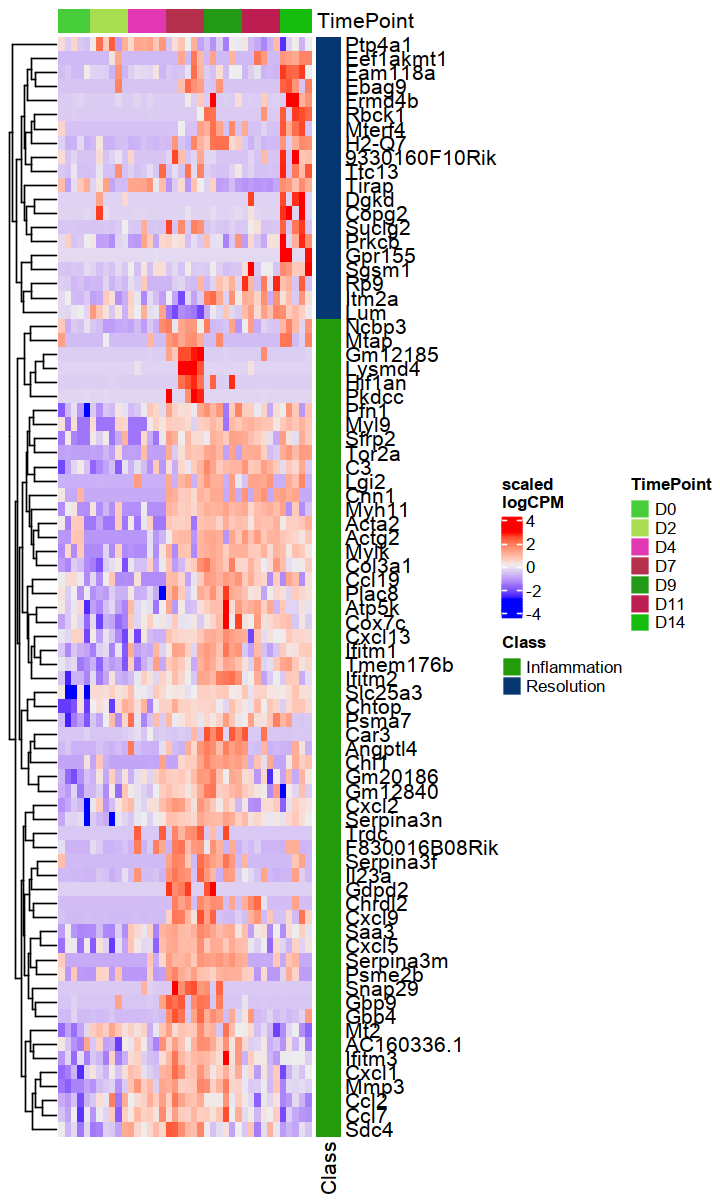

In [672]:
fig.size(10, 6)
set.seed(45L)
Heatmap(
    X, 
    cluster_columns = FALSE,
    name = 'scaled\nlogCPM',
    show_column_names = FALSE,
    top_annotation = columnAnnotation(df = dplyr::select(m, TimePoint)),
    right_annotation = rowAnnotation(df = data.frame(group=hres)),
)

## Plot enrichment stats

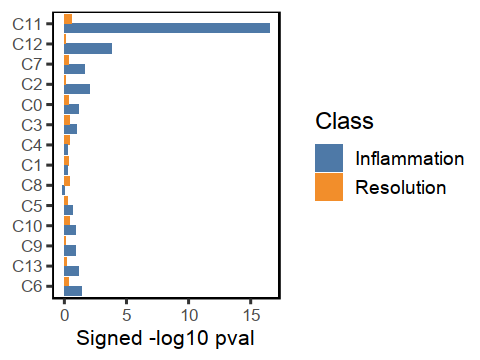

In [676]:
fig.size(3, 4)
enrich_res %>% 
    ggplot(aes(reorder(Cluster, zscore), sign(zscore) * -log10(p), fill = Class)) + 
#     ggplot(aes(reorder(Cluster, zscore), zscore, fill = Class)) + 
        geom_bar(stat = 'identity', position = position_dodge()) + 
        scale_fill_tableau() + 
        coord_flip() + 
#         geom_hline(yintercept = -log10(.01), linetype = 2) + 
        labs(y = 'Signed -log10 pval') + 
        theme(axis.title.y = element_blank()) + 
        NULL


## Time course of C11 leading edge genes 

In [589]:
# effects_mm %>% 
#     subset(Cluster == 'C11') %>% 
#     subset(feature %in% rownames(subset(hres, Class == 'Inflam'))) %>% 
# #     arrange(-beta)
#     subset(pvalue < .05) %>% 
#     arrange(-zscore)


In [506]:
m <- meta_data %>% 
    dplyr::mutate(TimeInt = case_when(
        Case == 'SS' ~ 0L, 
        TRUE ~ TimeInt
    )) %>% 
    dplyr::mutate(TimePoint = case_when(
        Case == 'SS' ~ 'D0', 
        TRUE ~ TimePoint
    )) %>% 
    dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14))))



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



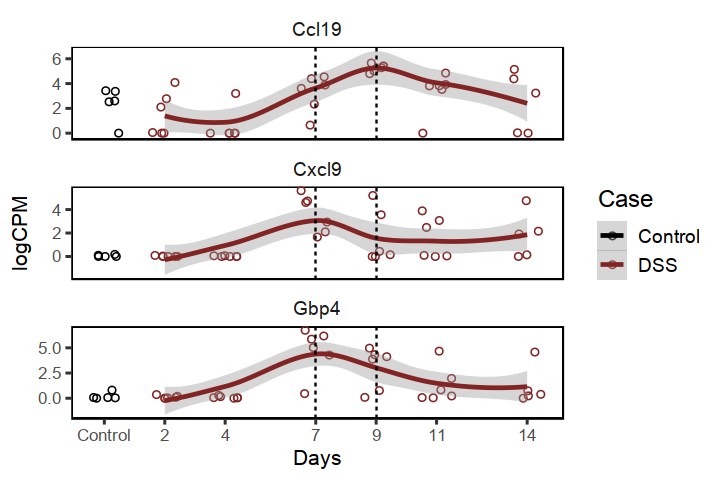

In [620]:
# .genes <- c('Ccl2', 'Ccl19', 'Ifitm1')
.genes <- c('Cxcl9', 'Ccl19', 'Gbp4')


fig.size(4, 6)
m %>% 
    cbind(as.matrix(t(logcpm[.genes, m$LibraryID]))) %>% 
    tidyr::gather(key, val, one_of(.genes)) %>%
    dplyr::mutate(Case = c(SS='Control', DSS='DSS')[Case]) %>% 
    ggplot(aes(TimeInt, val, color = Case)) + 
        geom_point(shape = 21, position = position_jitter(width = .5, height = 0)) + 
        geom_smooth() + 
        facet_wrap(~key, scales = 'free_y', ncol = 1) + 
        scale_x_continuous(breaks = c(0, 2, 4, 7, 9, 11, 14), labels = c('Control', '2', '4', '7', '9', '11', '14')) + 
        labs(y = 'logCPM', x = 'Days') + 
        geom_vline(xintercept = c(7, 9), linetype = 2) + 
        scale_color_manual(values = c('black', muted('red'))) +  
        NULL
        

## Noise in C4 genes

In [593]:
m <- meta_data %>% 
    dplyr::mutate(TimeInt = case_when(
        Case == 'SS' ~ 0L, 
        TRUE ~ TimeInt
    )) %>% 
    dplyr::mutate(TimePoint = case_when(
        Case == 'SS' ~ 'D0', 
        TRUE ~ TimePoint
    )) %>% 
    dplyr::mutate(TimePoint = factor(TimePoint, paste0('D', c(0, 2, 4, 7, 9, 11, 14))))



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



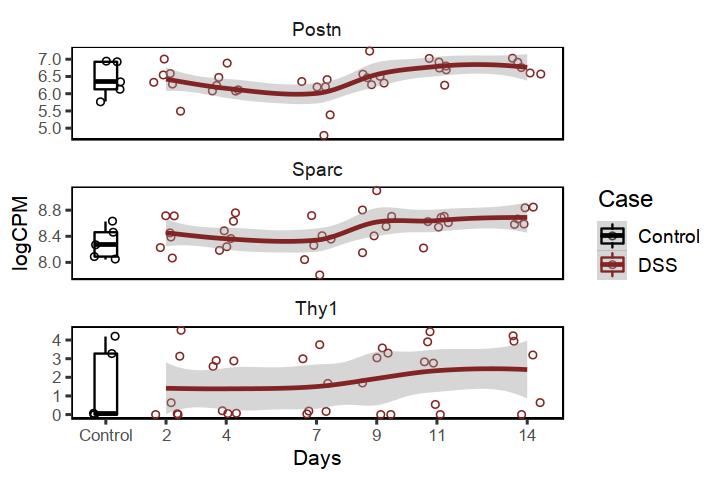

In [622]:
# .genes <- c('Ccl2', 'Ccl19', 'Ifitm1')
# .genes <- c('Cxcl9', 'Ccl19', 'Gbp4')
.genes <- c('Postn', 'Thy1', 'Sparc')


fig.size(4, 6)
m %>% 
    cbind(as.matrix(t(logcpm[.genes, m$LibraryID]))) %>% 
    tidyr::gather(key, val, one_of(.genes)) %>%
    dplyr::mutate(Case = c(SS='Control', DSS='DSS')[Case]) %>% 
    ggplot(aes(TimeInt, val, color = Case)) + 
        geom_point(shape = 21, position = position_jitter(width = .5, height = 0)) + 
        geom_smooth() + 
        geom_boxplot(data = . %>% subset(Case == 'Control'), fill = NA, outlier.shape = NA) + 
        facet_wrap(~key, scales = 'free_y', ncol = 1) + 
        scale_x_continuous(breaks = c(0, 2, 4, 7, 9, 11, 14), labels = c('Control', '2', '4', '7', '9', '11', '14')) + 
        labs(y = 'logCPM', x = 'Days') + 
#         geom_vline(xintercept = c(7, 9), linetype = 2) + 
        scale_color_manual(values = c('black', muted('red'))) +  
        NULL
        

# Etc. 

In [43]:
readRDS('/data/srlab2/ik936/Roche/data/cache/obj_fibroblasts/effects_nested.rds') %>% 
    subset(Tissue == 'Gut') %>% 
#     subset(feature %in% c('PDPN')) %>% 
    subset(feature %in% c('PDGFRA')) %>% 
    arrange(beta) %>% 
#     subset(Cluster %in% c('4', '11')) %>% 
    identity()


contrast,Cluster,Tissue,feature,beta,sigma,zscore,pvalue
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
13|Gut,13,Gut,PDGFRA,-1.19080972,0.3921574,-3.03656035,9.988035e-01
2|Gut,2,Gut,PDGFRA,-0.63858156,0.4111536,-1.55314583,9.398059e-01
8|Gut,8,Gut,PDGFRA,-0.60738919,0.2957177,-2.05394952,9.800097e-01
11|Gut,11,Gut,PDGFRA,-0.54245898,0.3019056,-1.79678347,9.638150e-01
9|Gut,9,Gut,PDGFRA,-0.48216965,0.3531001,-1.36553262,9.139571e-01
5|Gut,5,Gut,PDGFRA,-0.44852298,0.2830858,-1.58440641,9.434494e-01
3|Gut,3,Gut,PDGFRA,-0.41133975,0.3900642,-1.05454382,8.541830e-01
4|Gut,4,Gut,PDGFRA,-0.14666198,0.2973706,-0.49319593,6.890629e-01
7|Gut,7,Gut,PDGFRA,-0.01811226,0.3033093,-0.05971548,5.238089e-01
